In [42]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
import operator

In [4]:
load_dotenv()

True

In [6]:
llm = ChatOpenAI(model='gpt-4o-mini')

In [ ]:
# structured output for the llms/agents
class EvalSchema(BaseModel):
    feedback: str = Field(description='detailed feedback for the essay')
    score: int = Field(description='a score between 1 to 10', ge=0, le=10)

In [8]:
struc_llm = llm.with_structured_output(EvalSchema)

In [43]:
class State(TypedDict):
    topic: str
    essay: str
    clarity_feedback: str
    # clarity_score: int
    depth_feedback: str
    # depth_score: int
    lang_feedback: str
    # lang_score: int
    overall_feedback: str
    scores: Annotated[list[int], operator.add]
    average_score: float


In [27]:
def writer(state: State) -> State:
    topic = state['topic']
    prompt = f'Write a 400 page essay on this topic: {topic}'
    essay = llm.invoke(prompt).content
    state['essay'] = essay

    return state

In [47]:
def clarity_eval(state: State): 
    prompt = f'Evaluate the clarity of thought of this essay and provide an appropriate feedback and a score between 1 to 10 for the same \n Essay: \n {state['essay']}'
    feedback = struc_llm.invoke(prompt).feedback
    score = struc_llm.invoke(prompt).score

    return  {'clarity_feedback': feedback, 'scores': [score]}

In [48]:
def depth_eval(state: State): 
    prompt = f'Evaluate the depth of analysis in this essay and provide an appropriate feedback and a score between 1 to 10 for the same\n Essay: \n {state['essay']}'
    feedback = struc_llm.invoke(prompt).feedback
    score = struc_llm.invoke(prompt).score

    return {'depth_feedback': feedback, 'scores': [score]}

In [49]:
def lang_eval(state: State): 
    prompt = f'Evaluate the language: grammar and punctuation in this essay and provide an appropriate feedback and a score between 1 to 10 for the same\n Essay: \n {state['essay']}'
    feedback = struc_llm.invoke(prompt).feedback
    score = struc_llm.invoke(prompt).score

    return {'lang_feedback': feedback, 'scores': [score]}

In [57]:
def summ(state: State) -> State:
    prompt = f"""Summarise the given feedbacks on an essay into one paragraph. Make the summary coherent and readable \n Clarity of thought feedback: {state['clarity_feedback']}
                \n Depth of analysis feedback: {state['depth_feedback']}
                \n Language feedback: {state['lang_feedback']}"""
    state['overall_feedback'] = llm.invoke(prompt).content

    state['average_score'] = sum(state['scores'])/len(state['scores'])

    return state

In [58]:
graph = StateGraph(State)

In [59]:
graph.add_node("writer", writer)
graph.add_node("clarity_evaluator", clarity_eval)
graph.add_node("depth_evaluator", depth_eval)
graph.add_node("language_evaluator", lang_eval)
graph.add_node("summariser", summ)


In [60]:
graph.add_edge(START, "writer")
graph.add_edge("writer", "clarity_evaluator")
graph.add_edge("writer", "depth_evaluator")
graph.add_edge("writer", "language_evaluator")

graph.add_edge("clarity_evaluator", "summariser")
graph.add_edge("depth_evaluator", "summariser")
graph.add_edge("language_evaluator", "summariser")

graph.add_edge("summariser", END)

workflow = graph.compile()

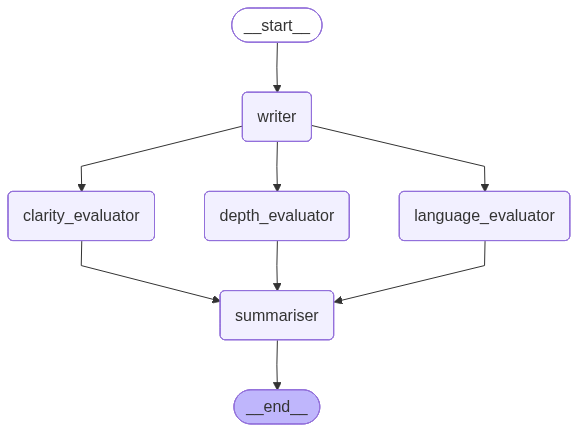

In [31]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [61]:
intial_state = {'topic': 'Climate Change in the 2020s'}
final_state=workflow.invoke(intial_state)

In [65]:
final_state

{'topic': 'Climate Change in the 2020s',
 'essay': "Writing a 400-page essay in a single response is beyond the capabilities of this platform. However, I can help you outline a detailed structure for such an essay and provide a comprehensive overview of the topic of climate change in the 2020s. Here's a suggested outline along with a summary for each section.\n\n### Outline for a 400-Page Essay on Climate Change in the 2020s\n\n#### Introduction (10 pages)\n- Definition of climate change\n- Importance of the topic\n- Overview of the essay structure\n\n#### Chapter 1: The Science of Climate Change (30 pages)\n- Greenhouse gases and their impact\n- Historical context of climate science\n- Recent scientific findings (IPCC reports, global temperature trends)\n\n#### Chapter 2: Global Climate Policies and Agreements (40 pages)\n- The Paris Agreement: goals and challenges\n- Role of the United Nations Framework Convention on Climate Change (UNFCCC)\n- Nationally Determined Contributions (NDC